# Model-based Inference
## Last time

* Presentation guidelines, portfolio meetings
* Fast Fourier Transform

## Today

* Multi-variate probabilistic models
* Adjoint-based methods
* MCMC for Bayesian inference

In [3]:
using LinearAlgebra
using Plots
using SparseArrays
default(linewidth=3, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Gaussian models

## One variable

Probability density

$$ p(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac 1 2 (x-\mu) \sigma^{-2} (x - \mu)}$$

where $\mu$ is the mean and $\sigma^2$ is the variance.

## Multivariate

Probability density

$$p(\mathbf x) = \lvert 2\pi \Sigma \rvert^{-1/2} \exp\Big(-\frac 1 2 (\mathbf x - \boldsymbol \mu)^T \Sigma^{-1} (\mathbf x - \boldsymbol \mu) \Big)$$

where $\boldsymbol\mu$ is the mean and $\Sigma$ is the covariance matrix.

## [Precision matrix](https://en.wikipedia.org/wiki/Precision_(statistics))

The covariance $\Sigma$ is rarely used directly in computation and is usually dense, while the **precision matrix** $P = \Sigma^{-1}$ is often sparse, representing **conditional independence**.

# Constrained optimization

Suppose we want to minimize an objective function over some design variables $d$

$$\min_d J(u,d)$$

subject to $f(u; d) = 0$.

Evidently it is possible to compute $u(d)$ by solving this constraint. That might mean solving a differential equation. An optimization algorithm will typically need the total derivative of $J$ with respect to the design variable $d$, which will involve differentiating $\partial u/\partial d$.

## Lagrange multipliers
We can instead seek stationary points of the Lagrangian
$$\mathcal L(u, \lambda, d) = J(u, d) + \lambda^T f(u; d)$$
which yields
\begin{align}
\nabla_u \mathcal L &= \nabla_u J + \lambda^T \nabla_u f(u; d) = 0 \\
\nabla_\lambda \mathcal L &= f(u; d) = 0 \\
\nabla_d \mathcal L &= \nabla_d J + \lambda^T \nabla_d f(u; d) = 0.
\end{align}

The algorithm is that given $d$, we solve the second equation to get $u$, then solve the first equation to get $\lambda$, at which point the last equation delivers the gradient.

# Quadratic objective with linear constraints

Consider minimizing
$$J(u,d) = \frac 1 2 (u - m)^T A (u - m) + \frac 1 2 d^T C d$$
(where $A$ is SPD and $C$ is symmetric positive semidefinite) subject to $f(u;d) = Bu - d = 0$.

## Interpretation

We might want to match (noisy) measurements $m$ where $A$ is an assumed precision matrix for the measurements and the design variables have a cost described by $C$.

## Solution
The Lagrangian is
\begin{align}\mathcal L(u, \lambda, d) &= \frac 1 2 (u-m)^T A (u - m) + \frac 1 2 d^T C d \\
&+ \lambda^T (Bu - d)
\end{align}
which has first order optimality conditions
$$\begin{bmatrix}
A & B^T & 0 \\
B & 0 & -I \\
0 & -I & C
\end{bmatrix}
\begin{bmatrix} u \\ \lambda \\ d \end{bmatrix} = \begin{bmatrix} A m \\ 0 \\ 0 \end{bmatrix}.$$
Evidently the optimal design $d$ can be computed by solving this linear system.

# Bayesian interpretation

Before collecting the measurements $m$, we have a prior probability
$$p(d) \sim \exp\Big( -\frac 1 2 d^T C d \Big),$$ which can also be written as $d$ is normally distributed with mean 0 and covariance $C^{-1}$,
$$ d \sim \mathcal N(0, C^{-1}).$$

After taking measurements $m$, we can describe the joint distibution

$$\begin{bmatrix} u \\ d \end{bmatrix} \sim \mathcal N \Big( \begin{bmatrix} m \\ 0  \end{bmatrix}, \begin{bmatrix} A & D^T \\ D & C \end{bmatrix}^{-1} \Big)$$
for some coupling matrix $D$ that describes satisfying the constraints.

We can produce a new **posterior** distribution for the design $d$ conditioned on the measurements $m$ using Bayes' Theorem,

$$p(d | m) \sim p(m | d) p(d)$$

where for our model,

$$p(m | d) \sim \exp\Big( -\frac 1 2 \big( u(d) - m \big)^T A \big(u(d) - m\big)\Big).$$

## Maximum a Posteriori (MAP) point
One might ask for $d$ that maximizes $p(d|m)$, or equivalently, $d$ that minimizes the negative log posterior:

$$-\log p(d|m) = \frac 1 2 \big(u(d) - m\big)^T A \big(u(d) - m\big) + \frac 1 2 d^T C d.$$

# Beyond Gaussian models

The math on the previous slide requires that
* the prior $p(d)$ is Gaussian and
* the model $u(d)$ is linear, i.e., $Bu = d$.
If either is not true, then $p(d|m)$ is no longer a Gaussian distribution.

## Variational Inference
Assume a Gaussian posterior anyway and solve the nonlinear least squares problems to find the MAP point. The covariance of $p(d|m)$ is represented by the Hessian of the negative log posterior.

## Bayesian Inference
We want to describe the non-Gaussian **distribution**, which generally has no closed form. This must be done by sampling.

# Bayesian sampling

## Naive Idea

Draw sample designs from the prior $p(d)$, solve the state equation to produce $u(d)$. Use the observational noise model to compute $p(m | u(d))$. Use Bayes' theorem to define posterior $p(d|m)$.

## Problem

It is very slow to explore the designs that are consistent with measurements. It's also unclear how to use the weighted posterior samples.

## Markov Chain Monte Carlo

As before, but
1. Take a random walk in design space (steps drawn from some distribution) to produce candidates $d'$ nearby to the most recently accepted $d_k$.
2. Define acceptance ratio $\alpha = p(d'|m) / p(d_k|m)$.
3. Draw a uniform random number from $[0,1]$ and if less than $\alpha$, accept the step by setting $d_{k+1} = d'$.

### Notes
* Some initial samples must be discarded ("burn in").
* We don't need a normalized posterior (which is good because normalization is expensive).
* The "chains" after burn-in are samples from the posterior.

# Variational versus sampling

* Variational methods can be used in high dimensions (millions or billions of design variables).
  * At least to find the MAP point (deterministic nonlinear optimization)
  * Use low-rank methods to approximate the most parts of the Hessian (i.e., subspace in which data is most informative).
  * Cannot capture non-Gaussian posterior effects
  * Gradient-based optimization requires gradients (adjoints)
* Sampling is much more expensive, especially in high dimensions
  * Captures the full distribution (with enough samples)
  * High order statistics of the posterior are mostly intractable in high dimensions
  * Hamiltonian Monte Carlo uses gradient/Hessian information to sample more efficiently.
  * [Turing.jl](https://turinglang.org/dev/docs/using-turing/get-started) is a nice Julia package

# Example: advection

## Forward model
Consider the state variable $u(t,x)$ solving the advection equation
$$u_t + u_x = 0$$
with an objective defined in terms of $u(T, \cdot)$.

## Continuous adjoint model

Multiply by $\lambda$ and integrate by parts

\begin{align}
\lambda(u_t + u_x) &= u(-\lambda_t - \lambda_x)
\end{align}

Differentiating this product with respect to $u$ leaves the adjoint equation
$$-\lambda_t - \lambda_x = 0$$
which runs **backward in time**.

## Interpretation

The forward model is advection to the right.

The adjoint model (evolving backward in time) is advection to the left.

## Discrete (in space) adjoint

Forward model as $u_t = Au$.

Adjoint model is $\lambda_t = -A^T \lambda$, backward in time.

# Demo

In [47]:
x = LinRange(-1, 1, 100)
function advect_matrix(x) # upwinded
    c = .5 * (x[1:end-1] + x[2:end])
    L = x[end] - x[1]
    dx = diff([c[end] - L; c; c[1] + L])
    n = length(c)
    rows = Int[]
    cols = Int[]
    vals = Float64[]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i])
        append!(cols, wrap.([i-1, i]))
        append!(vals, [1., -1] ./ dx[i])
    end
    c, sparse(rows, cols, vals)
end
c, A = advect_matrix(x)
A = Matrix(A); # dense to use exp

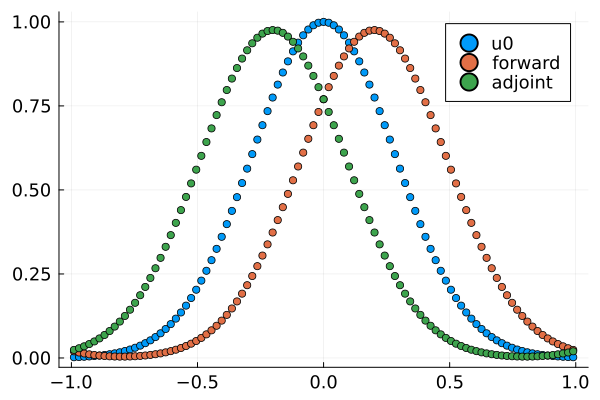

In [48]:
u0 = @. exp(-(c/.4)^2)
T = 0.2
u = exp(A * T) * u0
lam = exp(A' * T) * u0
scatter(c, [u0 u lam], label=["u0" "forward" "adjoint"])

# Non-uniform grid

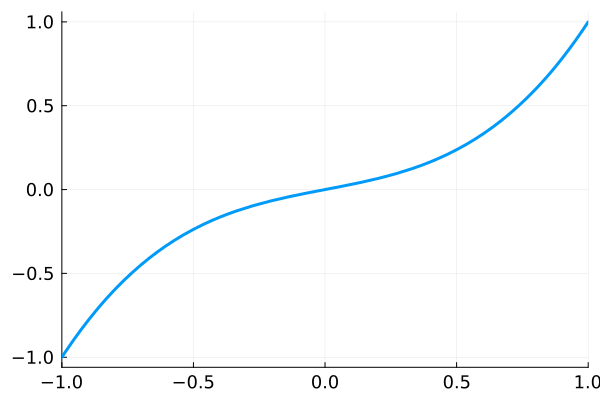

In [49]:
warp(x; s = 0.3) = s*x + (1-s)*x^3
plot(warp, xlim=(-1, 1), legend=:none)

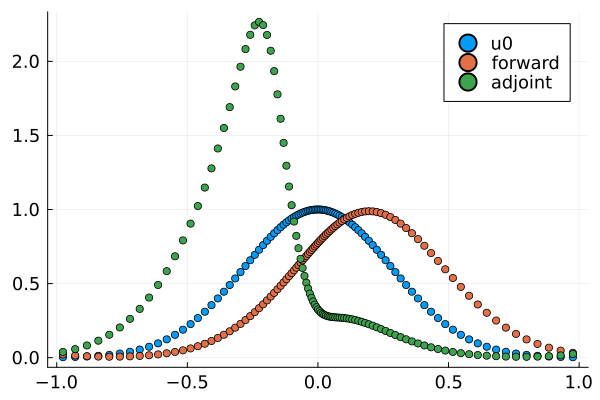

In [51]:
x = LinRange(-1, 1, 100)
y = warp.(x)
c, A = advect_matrix(y)
A = Matrix(A)
u0 = @. exp(-(c/.4)^2)
T = 0.2
u = exp(A * T) * u0
lam = exp(A' * T) * u0
scatter(c, [u0 u lam], label=["u0" "forward" "adjoint"])

In [42]:
@show norm(sum(A, dims=[2])) # row sums
@show norm(sum(A', dims=[2])); # row sums of adjoint operator 

norm(sum(A, dims = [2])) = 0.0
norm(sum(A', dims = [2])) = 33.55967467376903


33.55967467376903

# Discretization does not commute with differentiation!?!


* This is a big problem.
  * One hopes that the gradient computed by the adjoint method is a descent direction for an optimizer.
  * But the gradient of the discrete problem is physically nonsense, often leading to local minima.
  * The discretization of the continuous adjoint equation may not be a descent direction, but is probably conceptually more what you want.
* Some discretizations, such as  pure Galerkin methods, do commute.
* Such methods are insufficiently stable for most transport-dominated problems.
* Discretization methods like limiters for finite volume methods make this worse.